# Sanger - Sub-sampling

This Jupyter notebook reproduces the results from the B-ALL sub-sampling analysis (Supplementary Figure S5).

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

First, we read the insertions and CTGs that were identified at the different sequencing depths by IM-Fusion. These results have been pre-computed using an external Snakemake pipeline (see the documentation and the Makefile for more details).

In [2]:
depths = [15, 30, 50, 70]

# Read insertions.
insertions = pd.concat((pd.read_csv('../data/processed/sanger/star-subsample/'
                                    '{}/insertions.txt'.format(depth), sep='\t')
                          .query('support >= 10')
                          .assign(depth=depth)
                        for depth in depths), axis=0)

# Read CTGs.
ctgs = pd.concat((pd.read_csv('../data/processed/sanger/star-subsample/'
                              '{}/ctgs.txt'.format(depth), sep='\t')
                    .assign(depth=depth)
                  for depth in depths), axis=0)

Next, we plot the number of insertions and DE CTGs across the different sequencing depths to see how depth affects insertion/CTG detection:

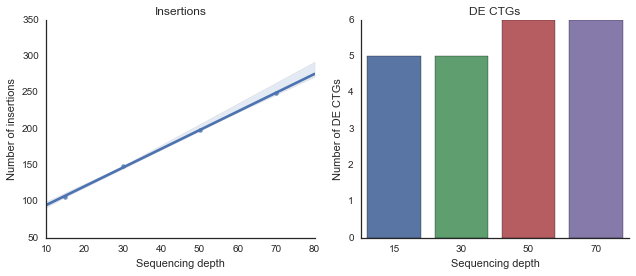

In [3]:
def plot_depth_ctg_count(ctgs, ax=None):
    if ax is None:
        _, ax = plt.subplots()
        
    counts = (ctgs.groupby('depth')['gene_name'].nunique()
                  .reset_index(name='count'))
    sns.barplot(data=counts, x='depth', y='count', ax=ax)
    
    ax.set_xlabel('Sequencing depth')
    ax.set_ylabel('Number of CTGs')

    ax.set_ylim(0, counts['count'].max())
    
    return ax


def plot_depth_insertion_count(insertions, ax=None, kind='bar'):
    if ax is None:
        _, ax = plt.subplots()
        
    counts = (insertions.groupby('depth')['id'].nunique()
                        .reset_index(name='count'))
    
    if kind == 'bar':
        sns.barplot(data=counts, x='depth', y='count', ax=ax)
    elif kind == 'reg':
        sns.regplot(data=counts, x='depth', y='count', ax=ax)
    else:
        raise ValueError('Unknown value for kind')
    
    ax.set_xlabel('Sequencing depth')
    ax.set_ylabel('Number of insertions')
    
    return ax


def plot_depth_overview(insertions, ctgs, axes=None):
    if axes is None:
        _, axes = plt.subplots(figsize=(9, 4), ncols=2, nrows=1)

    plot_depth_ctg_count(ctgs.query('de_pvalue < 0.05'), ax=axes[1])
    plot_depth_insertion_count(insertions, ax=axes[0], kind='reg')
    
    axes[0].set_title('Insertions')
    axes[1].set_title('DE CTGs')
    axes[1].set_ylabel('Number of DE CTGs')
    
    sns.despine()
    plt.tight_layout()
    
    return axes
    

fig, axes = plt.subplots(figsize=(9, 4), ncols=2)
plot_depth_overview(insertions, ctgs, axes=axes);


with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plt.subplots(figsize=(6, 3), ncols=2)
    plot_depth_overview(insertions, ctgs, axes=axes);

    fig.savefig('../reports/supplemental/figures/fig_s5ab_subsampling.pdf', bbox_inches='tight')
    plt.close(fig)

This shows that with increasing depth we identify linearly increasing numbers of insertions, but that the number of DE CTGs does not change strongly. To check if these CTGs are consistent across depths, we also plot a venn diagram of the identified CTGs:

{15: {'Bmi1', 'Cblb', 'Jak1', 'Stat5b', 'Zfp423'},
 30: {'Bmi1', 'Cblb', 'Jak1', 'Stat5b', 'Zfp423'},
 50: {'Bmi1', 'Cblb', 'Dlx3', 'Jak1', 'Stat5b', 'Zfp423'},
 70: {'Bmi1', 'Cblb', 'Dlx3', 'Jak1', 'Stat5b', 'Zfp423'}}

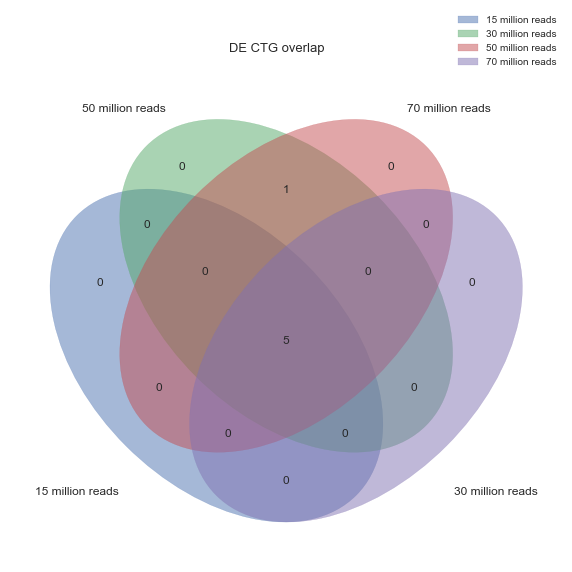

In [4]:
from nbsupport.venn import venn

ctg_genes = {depth: set(grp.query('de_pvalue <= 0.05')['gene_name'])
              for depth, grp in ctgs.groupby('depth')}

fig = venn([ctg_genes[d] for d in depths],
           names=['{} million reads'.format(i) for i in depths],
           colors=sns.color_palette())
fig.suptitle('DE CTG overlap', fontsize=13, y=0.85)

with sns.plotting_context('paper', font_scale=0.7):
    fig = venn([ctg_genes[d] for d in depths],
               names=['{} million reads'.format(i) for i in depths],
               colors=sns.color_palette(), figsize=(6, 5))
    fig.suptitle('DE CTG overlap', fontsize=7, y=0.85)

    fig.savefig('../reports/supplemental/figures/fig_s5c_subsampling_venn.pdf', bbox_inches='tight')
    plt.close(fig)
    
    
ctg_genes

This confirms that one additional CTG is identified with 50/70 million reads and that 5 CTGs are identified across all depths.

To determine if we find similar support (in terms of number of samples) across the different depths, we also count the number of samples with insertions in each CTG across the sequencing depths:

In [5]:
depth_overview = pd.pivot_table(ctgs.query('de_pvalue < 0.05'), index='gene_name',
                                columns='depth', values=['n_samples'])

depth_overview

n_samples               
depth            15   30   50   70
gene_name                         
Bmi1            2.0  2.0  2.0  2.0
Cblb            5.0  5.0  5.0  5.0
Dlx3            NaN  NaN  2.0  2.0
Jak1            7.0  7.0  7.0  9.0
Stat5b          5.0  7.0  7.0  7.0
Zfp423          2.0  2.0  2.0  2.0

This shows that additional insertions in Jak1, Stat5b and Dlx3 are detected at the higher depths, demonstrating that additional insertions are identified at higher depths. This indicates that, although we identify the same CTGs at different depths, deeper sequencing is beneficial for the sensitivity of insertion detection.